In [1]:
# from kerasdatasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

Using TensorFlow backend.


In [11]:
def discriminator():
    D = Sequential()
    depth = 64
    dropout = 0.4
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=645
    input_shape = (28, 28, 1)
    D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
    padding='same', activation=LeakyReLU(alpha=0.2)))
    D.add(Dropout(dropout))
    D.add(Conv2D(depth*2, 5, strides=2, padding='same',\
    activation=LeakyReLU(alpha=0.2)))
    D.add(Dropout(dropout))
    D.add(Conv2D(depth*4, 5, strides=2, padding='same',\
    activation=LeakyReLU(alpha=0.2)))
    D.add(Dropout(dropout))
    D.add(Conv2D(depth*8, 5, strides=1, padding='same',\
    activation=LeakyReLU(alpha=0.2)))
    D.add(Dropout(dropout))
    # Out: 1-dim probability
    D.add(Flatten())
    D.add(Dense(1))
    D.add(Activation('sigmoid'))
    D.summary()
    return D

In [12]:
def generator():
    G = Sequential()
    dropout = 0.4
    depth = 64+64+64+64
    dim = 7
    # In: 100
    # Out: dim x dim x depth
    G.add(Dense(dim*dim*depth, input_dim=100, activation = 'relu'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))
    G.add(Reshape((dim, dim, depth)))
    G.add(Dropout(dropout))
    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    G.add(UpSampling2D())
    G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))
    G.add(UpSampling2D())
    G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))
    G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))
    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    G.add(Conv2DTranspose(1, 5, padding='same'))
    G.add(Activation('sigmoid'))
    G.summary()
    return G

In [14]:
import keras
optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(discriminator())
DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
metrics=['accuracy'])
DM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 512)         3277312   
__________

In [17]:
optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(generator())
AM.add(discriminator())
AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
metrics=['accuracy'])
AM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_15 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       819328    
__________

In [25]:
from keras.datasets import mnist
generator = generator()
batch_size = 256
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# images_train = x_train[np.random.randint(0,x_train.shape[0], size=batch_size), :, :, :]
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
images_fake = generator.predict(noise)
x = np.concatenate((images_train, images_fake))
y = np.ones([2*batch_size, 1])
y[batch_size:, :] = 0
d_loss = discriminator.train_on_batch(x, y)
y = np.ones([batch_size, 1])
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_13 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_21 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 14, 14, 128)       819328    
__________

KeyboardInterrupt: 

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  5%|▍         | 6/128 [00:00<00:02, 51.96it/s]

Epoch 2


  5%|▍         | 6/128 [00:00<00:02, 54.32it/s]

Epoch 3


  5%|▍         | 6/128 [00:00<00:02, 54.63it/s]

Epoch 4


  5%|▍         | 6/128 [00:00<00:02, 54.81it/s]

Epoch 5


  5%|▍         | 6/128 [00:00<00:02, 54.94it/s]

Epoch 6


  5%|▍         | 6/128 [00:00<00:02, 55.49it/s]

Epoch 7


  5%|▍         | 6/128 [00:00<00:02, 54.50it/s]

Epoch 8


  5%|▍         | 6/128 [00:00<00:02, 54.29it/s]

Epoch 9


  5%|▍         | 6/128 [00:00<00:02, 50.97it/s]

Epoch 10


  5%|▍         | 6/128 [00:00<00:02, 50.94it/s]

Epoch 11


  5%|▍         | 6/128 [00:00<00:02, 55.32it/s]

Epoch 12


  5%|▍         | 6/128 [00:00<00:02, 54.47it/s]

Epoch 13


  5%|▍         | 6/128 [00:00<00:02, 54.76it/s]

Epoch 14


  5%|▍         | 6/128 [00:00<00:02, 55.12it/s]

Epoch 15


  5%|▍         | 6/128 [00:00<00:02, 54.90it/s]

Epoch 16


  5%|▍         | 6/128 [00:00<00:02, 54.44it/s]

Epoch 17


  5%|▍         | 6/128 [00:00<00:02, 54.88it/s]

Epoch 18


  5%|▍         | 6/128 [00:00<00:02, 55.03it/s]

Epoch 19


  5%|▍         | 6/128 [00:00<00:02, 54.57it/s]

Epoch 20


100%|██████████| 128/128 [00:02<00:00, 54.08it/s]


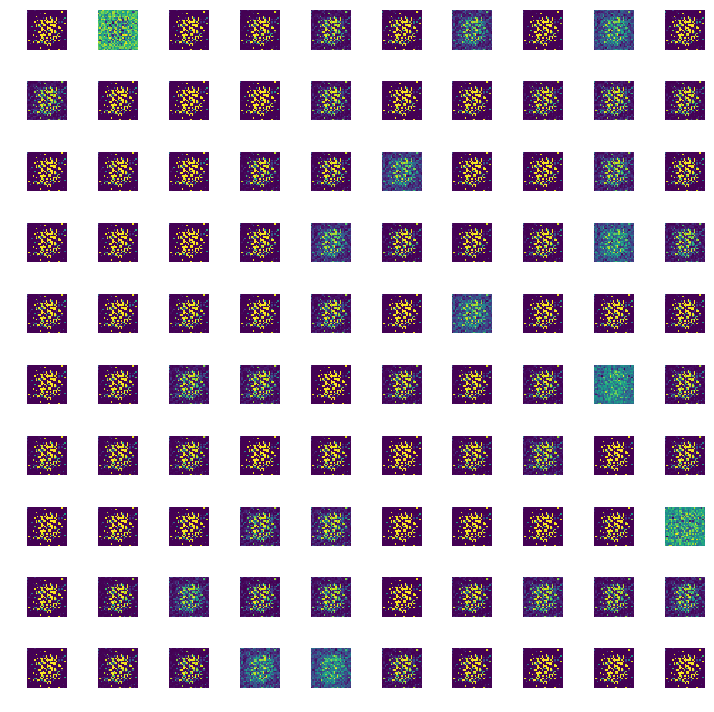

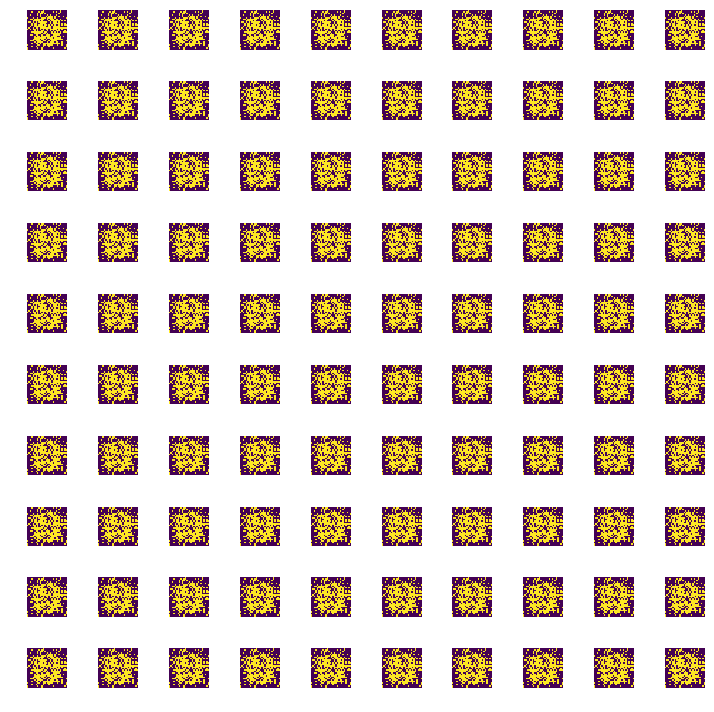

In [18]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
#     plt.savefig('gan_generated_image %d.png' %epoch)

def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(20,128)



ValueError: x and y can be no greater than 2-D, but have shapes (28,) and (28, 28, 1)

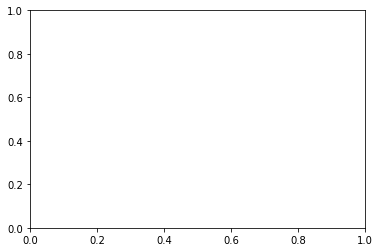

In [38]:

# noise = np.random.normal(0, 1, size=[128, 100])
# noise = noise.reshape(128,28,28)
examples = 1
noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
generated_images = generator.predict(noise)
generated_images = generated_images.reshape(28,28,1)
# predict = generator.predict(noise)
plt.plot(generated_images)
# predict.shape
# noise.shape